In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import random
from itertools import product

import torch

In [2]:

def get_device() -> str:
    """
    Returns the device that available for use. 
    Priority:  GPU (CUDA) > M1 (MPS) > CPU
    
    Returns:
        string of device name
    """
    
    if torch.cuda.is_available():
        return "cuda"
    if hasattr(torch.backends, "mps"):
        if torch.backends.mps.is_available() and torch.backends.mps.is_built():
            return "mps"
    return "cpu"

# Prepare data

In [327]:
df = pd.read_csv("data/real.csv",index_col=0)

In [328]:
df = df.iloc[0:,[0,1,2]]

In [329]:
df.head()

,Store,User,Rating
0,NAP's Coffee & Roasters,Nuunet D.,5
1,NAP's Coffee & Roasters,vanai sun,3
2,NAP's Coffee & Roasters,Phonanan Seeon,5
3,NAP's Coffee & Roasters,Chavakorn Laophetsakunchai,5
4,NAP's Coffee & Roasters,community man,5


In [330]:
pivot = df.pivot_table(index='User',columns="Store",values="Rating")
pivot = pivot.fillna(0)

In [331]:
def get_indices(m: np.ndarray) -> np.ndarray:
    n_row, n_col = m.shape
    
    # create the meshgrid
    row_indices, col_indices = np.meshgrid(np.arange(n_row), np.arange(n_col), indexing='ij')
    index_pairs = np.vstack((row_indices.flatten(), col_indices.flatten())).T
    
    return index_pairs


def get_rating_indices(m: np.ndarray) -> np.ndarray:
    indices = get_indices(m)
    
    res = []

    for index in indices:
        # print(index)
        v = (pivot_m[index[0], index[1]])
        if v == 0:
            continue

        res.append(index)

    np.random.shuffle(res)
    
    return res
    

def fill_nan_from_indices(m: np.ndarray, indices: np.ndarray) -> np.ndarray:
    tmp_m = m.copy()
    
    for index in indices:
        tmp_m[index[0], index[1]] = 0
        
    return tmp_m

In [332]:
fill_nan_percentage = 0.2

pivot_m = pivot.values.copy()
rating_indices = get_rating_indices(pivot_m)

nan_indices = rating_indices[0: int(len(rating_indices) * fill_nan_percentage)]

new_pivot_m = fill_nan_from_indices(pivot_m, nan_indices)

In [333]:
pivot_m

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 5., 0., 0.]])

In [334]:
rating_indices[0:15]

[array([713,   6]),
 array([1695,   20]),
 array([1040,   16]),
 array([982,  19]),
 array([375,  17]),
 array([214,  23]),
 array([1002,   16]),
 array([883,  26]),
 array([832,   9]),
 array([1466,    5]),
 array([1759,   32]),
 array([991,   2]),
 array([17, 15]),
 array([1937,    9]),
 array([635,  11])]

In [335]:
pivot_m[206]

array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [336]:
new_pivot_m[206]

array([0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [337]:
mask = (pivot_m != 0) ^ (new_pivot_m != 0)

In [338]:
pivot_m.shape

(2237, 33)

In [339]:
new_pivot_m.shape

(2237, 33)


# Model Svds

In [370]:
U, sigma, Vt = svds(pivot_m,k=15)
matrix_reconstructed = U.dot(np.diag(sigma)).dot(Vt)

In [371]:
matrix_reconstructed

array([[-0.01580318, -0.03030373, -0.00105618, ..., -0.02549472,
        -0.00129405,  0.05699079],
       [ 0.0292148 ,  0.06780851,  0.050623  , ..., -0.05215704,
         0.00603001,  0.24663119],
       [ 0.06302732,  0.02851513,  0.148359  , ...,  0.06192996,
         0.01398883,  0.09414609],
       ...,
       [ 0.0342753 ,  0.01474135,  0.11307102, ..., -0.01742314,
         0.02871265, -0.05978153],
       [ 0.19785536,  0.08378007,  0.27686381, ...,  0.15522807,
         0.04990312,  0.1766168 ],
       [ 0.06192996,  0.02642722,  0.16256546, ...,  0.13477898,
         0.01009895,  0.05783212]])

In [372]:
np.isnan(new_pivot_m).any()

False

In [373]:
np.isnan(pivot_m).any()

False

# Evaluations model Metric

In [374]:
real = ((pivot_m[mask] - matrix_reconstructed[mask]) ** 2).mean()

In [375]:
real

3.6363485816198113

In [376]:
mse = np.mean((pivot_m - matrix_reconstructed)**2)
mse

0.1704018714671561

In [377]:
rmse = np.sqrt(mse)
rmse

0.4127976156267816

In [378]:
nrmse = rmse / (np.max(pivot_m) - np.min(pivot_m))
nrmse

0.08255952312535632

In [379]:
data = {"mse" : mse,
        "rmse": rmse,
        "nrmse": nrmse
       }

In [380]:
loss_functions = pd.DataFrame(data,index=['values'])

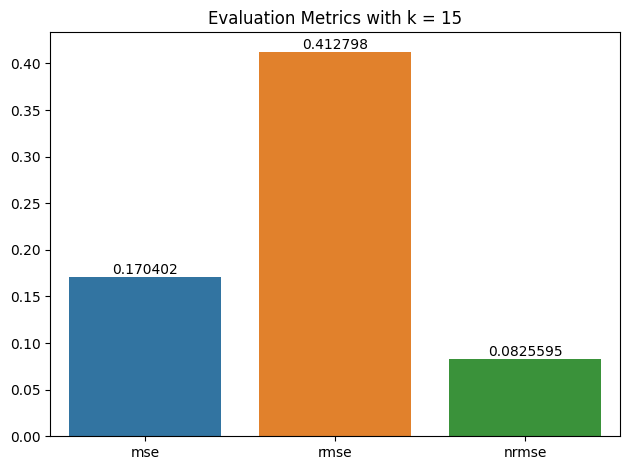

In [381]:

ax = sns.barplot(data=loss_functions)
ax.set_title("Evaluation Metrics with k = 15")
ax.bar_label(ax.containers[0])


plt.tight_layout()
plt.savefig("plot.png", dpi=300)


## Another Versions

In [392]:
class CFRecommender2:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, projects_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.projects_df = projects_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_projects(self, donor_id, projects_to_ignore=[], topn=10):
        # Get and sort the donor's predictions
        sorted_donor_predictions = self.cf_predictions_df[donor_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={donor_id: 'recStrength'})
        
        # Recommend the highest predicted projects that the donor hasn't donated to
        recommendations_df = sorted_donor_predictions[~sorted_donor_predictions['Store'].isin(projects_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        return recommendations_df

In [383]:
preds_df = pd.DataFrame(matrix_reconstructed, 
                           columns = pivot.columns, 
                           index=pivot.index).transpose()

In [384]:
preds_df.head()

User,01 มติมนต์ จํานงค์,113_kammika raksa,1904x,1984whatthehell,212ปาณิตตา ศิริชัย,321 321,53phenix,9ณัฐวลัญช์ พบบุญ,A -yo,A T,...,ไพจิต ศิลารักษ์,ไวไว อิอิ,ປາກເຊແດນງາມ Tubes,ᔕ νιяāкōяη,章詠乾,蔡賢德Karanpon,김주일,남궁진영,박선아,은하
Store,,,,,,,,,,,,,,,,,,,,,
11.11 Gallery and Coffee,-0.015803,0.029215,0.063027,0.071555,0.086291,0.067923,0.304221,0.018933,0.027420,0.489118,...,-0.004854,0.090944,0.060288,-0.003883,-0.003883,0.009961,-0.010948,0.034275,0.197855,0.061930
Abe Specialty Coffee,-0.030304,0.067809,0.028515,0.001583,0.040481,0.028623,0.093605,0.006892,0.011793,0.168515,...,-0.027213,0.062019,0.045388,-0.021770,-0.021770,-0.011679,0.017091,0.014741,0.083780,0.026427
Amarna,-0.001056,0.050623,0.148359,0.112386,0.219765,0.169858,0.784880,0.006795,0.090457,1.152802,...,-0.057452,0.249348,0.008552,-0.045962,-0.045962,0.021373,0.001106,0.113071,0.276864,0.162565
Anna Roasters,0.000390,0.004129,-0.023109,4.971379,0.048251,0.078194,-0.085431,-0.001848,-0.014246,3.908287,...,-0.005676,0.142934,-0.001576,-0.004541,-0.004541,-0.003899,-0.009121,-0.017807,-0.022702,-0.037182
Attaroast,0.003699,0.132550,0.086291,0.069067,0.141565,0.102470,0.452472,0.004163,0.105448,0.653828,...,-0.053491,0.160931,-0.036855,-0.042793,-0.042793,-0.040461,0.041631,0.131810,0.157883,0.103943


In [385]:
pivot[pivot.index == 'Nuunet D.'].idxmax(1)

User
Nuunet D.    NAP's Coffee & Roasters
dtype: object

In [393]:
tes = CFRecommender2(preds_df,pivot)

In [395]:
tes.recommend_projects("1904x")

,Store,recStrength
0,Nap x Warin,0.276800
1,Impression Sunrise,0.257274
2,Saereesook,0.246346
3,Amarna,0.148359
4,ROSIEHOLM,0.113205
5,SongSarn,0.103191
6,LIFE Roasters,0.094664
7,sangob,0.094146
8,BaanHuakham Cafe & Farmstay,0.088122
9,Attaroast,0.086291


# Pytorch Neural Network

In [25]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [26]:
data = df.copy()

In [27]:
data

,Store,User,Rating
0,NAP's Coffee & Roasters,Nuunet D.,5
1,NAP's Coffee & Roasters,vanai sun,3
2,NAP's Coffee & Roasters,Phonanan Seeon,5
3,NAP's Coffee & Roasters,Chavakorn Laophetsakunchai,5
4,NAP's Coffee & Roasters,community man,5
...,...,...,...
3348,Yuanjai Cafe,อาจณรงค์ กลมเกลียว,5
3349,Yuanjai Cafe,은하,5
3350,Yuanjai Cafe,ประจงจิต จันทป,5
3351,Yuanjai Cafe,Chatthawat Warnjai,5


In [28]:
device = get_device()

In [29]:
device

'mps'

In [111]:

class VanillaMF(nn.Module):
    """
    An implementation of vanilla matrix factorization model.
    """
    
    def __init__(self, n_users: int, n_items: int, latent_dim: int = 10):
        super().__init__()
        
        self.user_embeddings = nn.Embedding(n_users, latent_dim)
        self.item_embeddings = nn.Embedding(n_items, latent_dim)
        
        self.user_h1 = nn.Linear(latent_dim, latent_dim // 2)
        self.item_h1 = nn.Linear(latent_dim, latent_dim // 2)
        
        self.user_h1_dropout = nn.Dropout(0.25)
        self.item_h1_dropout = nn.Dropout(0.25)
        
    def forward(self, user_ids: torch.Tensor, item_ids: torch.Tensor) -> torch.Tensor:
        user_emb = self.user_embeddings(user_ids).squeeze(dim=1)  # (batch_size, latent_dim)
        item_emb = self.item_embeddings(item_ids).squeeze(dim=1)  # (batch_size, latent_dim)
        
        user_h1 = self.user_h1(user_emb)
        item_h1 = self.user_h1(item_emb)
        
        user_h1 = self.user_h1_dropout(user_h1)
        item_h1 = self.item_h1_dropout(user_h1)
        
        
        
        return (user_h1 * item_h1).sum(dim=1)  # (batch_size, )

    def loss_fn(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Simple MSE loss as the loss function for the model.
        
        Args:
            preds: predicted scores
            targets: ground truth scores
            
        Returns:
            MSE of the predictions and the ground truth
        """
        
        # return nn.MSELoss()(preds, targets)  # use package to calculate loss
        return ((preds - targets) ** 2).mean()

In [112]:
class RegularizedMF(VanillaMF):
    """
    Regularized matrix factorization model.
    
    References:
        - https://developers.google.com/machine-learning/recommendation/collaborative/matrix
        - https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb
    """
    
    def __init__(self, 
                 n_users: int, 
                 n_items: int, 
                 latent_dim: int = 10,
                 reg_coef: float = 0.1,
                 gravity_coeff: float = 1.):
        super().__init__(n_users, n_items, latent_dim)
        
        self.reg_coef = reg_coef
        self.gravity_coeff = gravity_coeff
    
    def regularization_loss(self) -> torch.Tensor:
        """
        Calculate the regularization loss.
        
        Returns:
            regularization loss
        """
        
        user_reg_loss = self.user_embeddings.weight.norm(p=2, dim=1).mean()
        item_reg_loss = self.item_embeddings.weight.norm(p=2, dim=1).mean()
        
        return self.reg_coef * (user_reg_loss + item_reg_loss)
    
    def gravity_loss(self) -> torch.Tensor:
        """
        Calculate the gravity loss.
        
        Returns:
            gravity loss
        """
        
        user_emb = self.user_embeddings.weight  # (n_users, latent_dim)
        item_emb = self.item_embeddings.weight  # (n_items, latent_dim)
        
        denominator = (user_emb.shape[0] * item_emb.shape[0]) * ((user_emb.T @ user_emb) * (item_emb.T @ item_emb)).sum()
        
        return self.gravity_coeff * 1 / denominator

    def loss_fn(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        MSE loss with regularization.
        
        Args:
            preds: predicted scores
            targets: ground truth scores
            
        Returns:
            MSE of the predictions and the ground truth
        """
        
        return super().loss_fn(preds, targets) + self.regularization_loss() + self.gravity_loss()

In [113]:
user2idx = {user: idx for idx, user in enumerate(data.User.unique())}
idx2user = {idx: user for user, idx in user2idx.items()}

item2idx = {item: idx for idx, item in enumerate(data.Store.unique())}
idx2item = {idx: item for item, idx in item2idx.items()}

In [114]:
encoded_df = data.copy()

encoded_df["User"] = encoded_df["User"].map(user2idx)
encoded_df["Store"] = encoded_df["Store"].map(item2idx)

pd.pivot_table(encoded_df, values='Rating', index='User', columns='Store')

Store,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User,,,,,,,,,,,,,,,,,,,,,
0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,NaN,5.0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [115]:
N_EPOCH = 20
BATCH_SIZE = 521
LEARNING_RATE = 0.02
LATENT_DIM = 3

In [116]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        user_id = self.df.iloc[idx].User
        item_id = self.df.iloc[idx].Store
        rating = self.df.iloc[idx].Rating
        
        return user_id.astype("int"), item_id.astype("int"), rating.astype("float32")

In [117]:
# Train test split
train_df = encoded_df.copy().sample(frac=0.6, random_state=1)
test_df = encoded_df.copy().drop(train_df.index)

# Create dataloader
train_loader = DataLoader(
    CustomDataset(train_df.copy()),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_loader = DataLoader(
    CustomDataset(test_df.copy()),
    batch_size=test_df.shape[0],
)

In [118]:
model = RegularizedMF(
    n_users=2237, 
    n_items=33,
    latent_dim=LATENT_DIM
).to(get_device())

print(model)

RegularizedMF(
  (user_embeddings): Embedding(2237, 3)
  (item_embeddings): Embedding(33, 3)
  (user_h1): Linear(in_features=3, out_features=1, bias=True)
  (item_h1): Linear(in_features=3, out_features=1, bias=True)
  (user_h1_dropout): Dropout(p=0.25, inplace=False)
  (item_h1_dropout): Dropout(p=0.25, inplace=False)
)


In [119]:
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [120]:
loss_hist = []
eval_loss_hist = []

for epoch in range(0, N_EPOCH):
    for i, (user_ids, item_ids, ratings) in enumerate(train_loader):
        user_ids = user_ids.to(device)
        item_ids = item_ids.to(device)
        ratings = ratings.to(device)
        
        # training
        _ = model.train()
        opt.zero_grad()
        
        pred_scores = model(user_ids, item_ids)
        loss = model.loss_fn(pred_scores, ratings)
        
        loss.backward()
        opt.step()
        
        # evaluation
        _ = model.eval()
        
        with torch.no_grad():
            eval_loss = 0
            for j, (user_ids, item_ids, ratings) in enumerate(test_loader):
                user_ids = user_ids.to(device)
                item_ids = item_ids.to(device)
                ratings = ratings.to(device)
                
                pred_scores = model(user_ids, item_ids)
                eval_loss += model.loss_fn(pred_scores, ratings)
                
            eval_loss /= len(test_loader)
        
        loss_hist.append(loss.item())
        eval_loss_hist.append(eval_loss.item())
        
    if epoch % 1 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item():.4f}, Eval Loss: {eval_loss.item():.4f}")

Epoch: 0, Loss: 16.9819, Eval Loss: 15.9681
Epoch: 1, Loss: 17.1121, Eval Loss: 15.7398
Epoch: 2, Loss: 15.5541, Eval Loss: 15.1873
Epoch: 3, Loss: 16.2573, Eval Loss: 14.6274
Epoch: 4, Loss: 15.8563, Eval Loss: 14.2298
Epoch: 5, Loss: 14.9092, Eval Loss: 14.0147
Epoch: 6, Loss: 14.0716, Eval Loss: 13.7041
Epoch: 7, Loss: 12.9670, Eval Loss: 13.1473
Epoch: 8, Loss: 12.6089, Eval Loss: 12.4043
Epoch: 9, Loss: 12.3262, Eval Loss: 11.6547
Epoch: 10, Loss: 12.1559, Eval Loss: 10.8445
Epoch: 11, Loss: 11.4980, Eval Loss: 9.7633
Epoch: 12, Loss: 10.3362, Eval Loss: 8.4451
Epoch: 13, Loss: 9.9017, Eval Loss: 7.1999
Epoch: 14, Loss: 10.3450, Eval Loss: 6.5181
Epoch: 15, Loss: 9.7406, Eval Loss: 6.5023
Epoch: 16, Loss: 9.1179, Eval Loss: 6.9455
Epoch: 17, Loss: 9.6089, Eval Loss: 7.5168
Epoch: 18, Loss: 9.9444, Eval Loss: 7.8836
Epoch: 19, Loss: 9.0324, Eval Loss: 7.9320


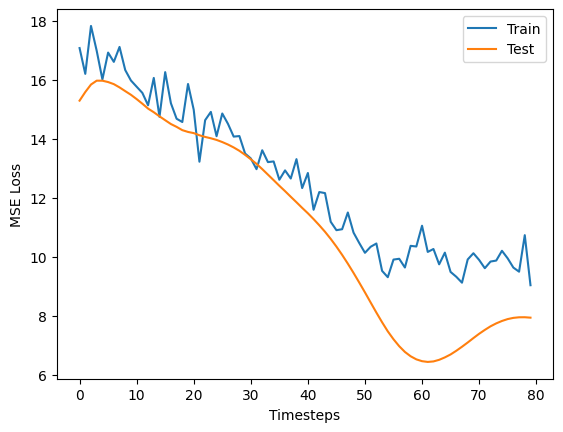

In [121]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

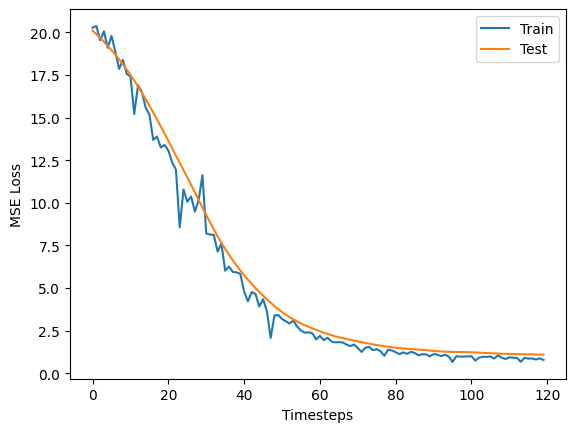

In [75]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

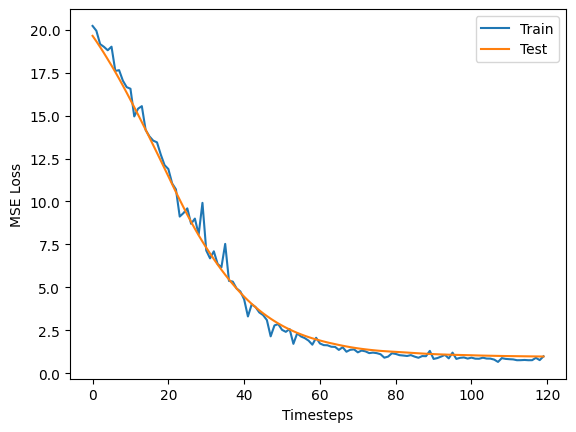

In [40]:
_ = plt.plot(loss_hist, label="Train")
_ = plt.plot(eval_loss_hist, label="Test")
_ = plt.xlabel("Timesteps")
_ = plt.ylabel("MSE Loss")
_ = plt.legend()

In [122]:
user_item_pair = list(product(range(2237), range(33)))
user_item_pair = np.array(user_item_pair)


In [123]:
_ = model.eval()

# Predict scores for all user-item pairs
user_ids = torch.IntTensor(user_item_pair[:, 0].copy()).to(device)
item_ids = torch.IntTensor(user_item_pair[:, 1].copy()).to(device)

pred = model(
    user_ids,
    item_ids
)

user_item_score = pd.DataFrame(user_item_pair.copy(), columns=["User", "Store"])
user_item_score["pred"] = pred.cpu().detach().numpy()


In [124]:
user_item_score

,User,Store,pred
0,0,0,1.772343
1,0,1,1.772343
2,0,2,1.772343
3,0,3,1.772343
4,0,4,1.772343
...,...,...,...
73816,2236,28,1.937826
73817,2236,29,1.937826
73818,2236,30,1.937826
73819,2236,31,1.937826


In [125]:
pd.pivot_table(user_item_score, values='pred', index='User', columns='Store').round(1)

Store,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
User,,,,,,,,,,,,,,,,,,,,,
0,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
1,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,...,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7,1.7
2,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,...,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6,1.6
3,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
4,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,...,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9,1.9
2233,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8
2234,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,...,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8,1.8


In [183]:
# Actual result
pibot = pd.pivot_table(encoded_df, values='Rating', index='User', columns='Store')

In [234]:
# Recommend top 5 movies for a particular user

user_id = 0
test  =  user_item_score[user_item_score.User == user_id].sort_values("pred", ascending=False)["Store"].values[:10]

In [235]:
idx2item

{0: "NAP's Coffee & Roasters",
 1: 'sangob',
 2: 'SongSarn',
 3: 'LIFE Roasters',
 4: 'Nap x Warin',
 5: 'BalconyKiss Coffee',
 6: 'Anna Roasters',
 7: 'ROOF COFFEE',
 8: '11.11 Gallery and Coffee',
 9: 'Abe Specialty Coffee',
 10: 'Amarna',
 11: 'Attaroast',
 12: 'BaanHuakham Cafe & Farmstay',
 13: 'Blendstorm Coffee Roasters',
 14: 'Blues Coffee',
 15: 'LAVA  JAVA Coffee Roasters',
 16: 'Bossa cafe',
 17: 'Commune Drink/Talk/Share',
 18: 'GODFATHER COFFEE',
 19: 'Impression Sunrise',
 20: 'MiND-K coffee and bake',
 21: 'My Papilio',
 22: 'PENSER CAFE',
 23: 'Phantae Coffee',
 24: 'REDCOFFEE',
 25: 'Rogue Roasters',
 26: 'ROSIEHOLM',
 27: 'r o u n d',
 28: 'Saereesook',
 29: 'Snoopcat Cafe',
 30: 'Stufe coffee',
 31: 'Tree Cafe Rim Moon',
 32: 'Yuanjai Cafe'}

In [190]:
{k: v for v, k in enumerate(test)}

{0: 0, 17: 1, 31: 2, 30: 3, 29: 4, 28: 5, 27: 6, 26: 7, 25: 8, 24: 9}

In [236]:
already = pibot[pibot.index == user_id].idxmax(1).values
for k,v in idx2item.items():
    if k in test:
        if k == already[0]:
            pass
        else:
            print(v)
    

Commune Drink/Talk/Share
REDCOFFEE
Rogue Roasters
ROSIEHOLM
r o u n d
Saereesook
Snoopcat Cafe
Stufe coffee
Tree Cafe Rim Moon


In [237]:
test

array([ 0, 17, 31, 30, 29, 28, 27, 26, 25, 24])